## Imports

In [2]:
%pip install pinecone-client datasets PyTDC rdkit datamol pandas numpy molfeat mols2grid tensorflow molecule_generation safe-mol


Note: you may need to restart the kernel to use updated packages.


In [3]:
import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from tdc.generation import MolGen
from pinecone import Pinecone, ServerlessSpec
import datamol as dm
from datamol.similarity import cdist
import molfeat
from molfeat.calc import FPCalculator, RDKitDescriptors2D
from molfeat.trans import MoleculeTransformer
from molfeat.store.modelstore import ModelStore
from molfeat.trans.pretrained import PretrainedMolTransformer, GraphormerTransformer
import mols2grid
import rdkit
from rdkit import Chem
import tensorflow as tf
import safe as sf

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


## Load data

In [3]:
from tdc.generation import MolGen
data = MolGen(name = 'ZINC')
split = data.get_split() 

Found local copy...
Loading...
Done!


In [4]:
split

{'train':                                                    smiles
 0                 CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1
 1       N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...
 2                 CC[NH+](CC)[C@](C)(CC)[C@H](O)c1cscc1Br
 3                    O=C(Nc1nc[nH]n1)c1cccnc1Nc1cccc(F)c1
 4         Cc1c(/C=N/c2cc(Br)ccn2)c(O)n2c(nc3ccccc32)c1C#N
 ...                                                   ...
 174613      COc1cc(C[NH2+]C[C@@H](C)C[C@@H](C)O)cc(Br)c1O
 174614                       COC(=O)c1cccc2nc(C=O)[nH]c12
 174615   CC1(C)CC[C@H](CNC(=O)Cn2ncc3ccccc3c2=O)c2ccccc21
 174616  Cn1ccnc1C(=O)c1ccc(NC(=O)C2CCN(C(=O)C(C)(C)C)C...
 174617             Cc1ccc(NC(=O)C(=O)N(C)Cc2ccccc2)c(C)c1
 
 [174618 rows x 1 columns],
 'valid':                                                   smiles
 0        C[C@@H](NC(=O)c1ccc(Br)cc1-n1cncn1)[C@@H]1CCOC1
 1          Cc1nc(N[C@@H](C)c2ccccc2-n2cccn2)c2nc(C)oc2n1
 2          CSc1ncc(C(=O)Nc2cccc(C(C)=O)c2)n1-c1ccc(F)cc1
 3         C

In [5]:
mols = dm.convert.from_df(split['test'])

In [6]:
## Make synthetic data for the 101st molecule

In [7]:
split['test'].iloc[100]

smiles    O=C(C[C@H]1CC[C@@H](C(=O)[O-])C1)c1ccc(Cl)cc1
Name: 100, dtype: object

In [8]:
query = split['test'].iloc[100].smiles

In [9]:
query

'O=C(C[C@H]1CC[C@@H](C(=O)[O-])C1)c1ccc(Cl)cc1'

## Featurize

In [10]:
df = dm.descriptors.batch_compute_many_descriptors(mols, properties_fn=None, add_properties=True, n_jobs=-1, batch_size='auto', progress=False, progress_leave=True)

[11:53:34] DEPRECATION WARNING: please use MorganGenerator
[11:53:34] DEPRECATION WARNING: please use MorganGenerator
[11:53:34] DEPRECATION WARNING: please use MorganGenerator
[11:53:34] DEPRECATION WARNING: please use MorganGenerator
[11:53:34] DEPRECATION WARNING: please use MorganGenerator
[11:53:34] DEPRECATION WARNING: please use MorganGenerator
[11:53:34] DEPRECATION WARNING: please use MorganGenerator
[11:53:34] DEPRECATION WARNING: please use MorganGenerator
[11:53:34] DEPRECATION WARNING: please use MorganGenerator
[11:53:34] DEPRECATION WARNING: please use MorganGenerator
[11:53:34] DEPRECATION WARNING: please use MorganGenerator
[11:53:34] DEPRECATION WARNING: please use MorganGenerator
[11:53:34] DEPRECATION WARNING: please use MorganGenerator
[11:53:34] DEPRECATION WARNING: please use MorganGenerator
[11:53:34] DEPRECATION WARNING: please use MorganGenerator
[11:53:34] DEPRECATION WARNING: please use MorganGenerator
[11:53:34] DEPRECATION WARNING: please use MorganGenerat

In [11]:
df['mols'] = mols

In [12]:
df['mol_id'] = [f'Molecule {i}' for i, _ in enumerate(df.mw)]

In [13]:
# # List all available featurizers
store = ModelStore()
store.available_models
model_card = store.search(name='pcqm4mv2_graphormer_base')[0]

In [14]:
store.available_models

[ModelInfo(name='cats2d', inputs='smiles', type='hashed', version=0, group='all', submitter='Datamol', description='2D version of the 6 Potential Pharmacophore Points CATS (Chemically Advanced Template Search) pharmacophore. This version differs from `pharm2D-cats` on the process to make the descriptors fuzzy, which is closer to the original paper implementation. Implementation is based on work by Rajarshi Guha (08/26/07) and Chris Arthur (1/11/2015)', representation='vector', require_3D=False, tags=['CATS', 'hashed', '2D', 'pharmacophore', 'search'], authors=['Michael Reutlinger', 'Christian P Koch', 'Daniel Reker', 'Nickolay Todoroff', 'Petra Schneider', 'Tiago Rodrigues', 'Gisbert Schneider', 'Rajarshi Guha', 'Chris Arthur'], reference='https://doi.org/10.1021/ci050413p', created_at=datetime.datetime(2023, 7, 20, 9, 40, 19, 315784), sha256sum='9c298d589a2158eb513cb52191144518a2acab2cb0c04f1df14fca0f712fa4a1', model_usage=None),
 ModelInfo(name='cats3d', inputs='mol', type='hashed', 

In [15]:
# featurizer = GraphormerTransformer(kind='pcqm4mv2_graphormer_base', dtype=np.float32, pooling='mean', max_length=None, concat_layers=-1, ignore_padding=True, version=None)
featurizer = PretrainedMolTransformer(kind='ChemGPT-1.2B', dtype=np.float32, pooling='mean', max_length=None, concat_layers=-1, ignore_padding=True, version=None)

In [16]:
# calc = FPCalculator("ecfp")
calc = RDKitDescriptors2D(replace_nan=True)

In [17]:
featurizer = MoleculeTransformer(calc, dtype=np.float32)

with dm.without_rdkit_log():
    feats = np.stack(featurizer(mols[:100]))

feats.shape

(100, 216)

## Configure Pinecone index

In [18]:
pc = Pinecone(api_key= "c2c9ba1d-9710-472b-a950-a3db5b40a67c")

In [19]:
index = pc.Index('molsearch')

### Upsert vectors

In [ ]:
id_list = [f'Molecule {i}' for i, _ in enumerate(feats)]

In [ ]:
payload = zip(id_list, feats)

In [ ]:
def chunks(iterable, batch_size=100):
    """A helper function to break an iterable into chunks of size batch_size."""
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

In [ ]:
for ids_vectors_chunk in chunks(payload, batch_size=10):
    index.upsert(vectors=ids_vectors_chunk) 

## Similarity search

In [ ]:
## Get 101st molecule and search

In [20]:
with dm.without_rdkit_log():
    feats = np.stack(featurizer(mols[100]))


In [21]:
query_results = index.query(vector = feats.tolist()[0], top_k = 100)

In [22]:
result_id = [query_results['matches'][id_no]['id'] for id_no in range(len(query_results['matches'])) ]

In [23]:
len(result_id)

100

In [10]:
import torch

In [14]:
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e

# set your device
DEVICE = torch.device('cpu')

In [15]:
# Model parameters are pulled from the url and stored in a local models/ dir.
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=DEVICE,
    # model parameters to load.
    doc_url="s3://terray-public/models/grande_closed.pkl",
)

Loading model from s3://terray-public/models/grande_closed.pkl


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
import coati
from coati.generative.coati_purifications import embed_smiles

# In this example, we use fentanyl as a reference molecule.
fentanyl_smiles = "CCC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3"
print("reference molecule:")
display(Chem.MolFromSmiles(fentanyl_smiles))

# We first convert the smiles to canonical smiles which is required by the model.
fentanyl_canonical_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(fentanyl_smiles))
# We then embed the canonical smiles to a 256D vector using the model.
fentanyl_vector = embed_smiles(fentanyl_canonical_smiles, encoder, tokenizer)

# We then generate 30 molecules near fentanyl. We do this by adding noise to the
# embedding vector which is then injected into the embed token in the prefix.
# The generated molecules are decoded back to smiles.
num_variations = 30
# noise is added as an isotropic Gaussian with std=noise_scale.
noise_scale = 0.3
smiles_near_fentanyl = encoder.hclip_to_2d_batch(
    h_clip=fentanyl_vector.unsqueeze(0).repeat(num_variations, 1),
    tokenizer=tokenizer,
    noise_scale=0.25,
)

# Visualize the generated molecules.
# Note that generated molecules are not guaranteed to be valid.
# Here we also use the set() function to remove duplicates.
print(f"Generated molecules (noise std={noise_scale}):")
display(
    Chem.Draw.MolsToGridImage(
        [
            Chem.MolFromSmiles(s)
            for s in set(smiles_near_fentanyl)
            if not Chem.MolFromSmiles(s) is None
        ],
        molsPerRow=4,
        useSVG=True,
    )
)

## Analyze hit similarity

In [ ]:
## Can estimate precision (> Tanimoto threshold in the returned set)
## Recall (Tanimoto for all in the dataset and see if retrieved top 100)
## Tanimoto as ground truth here


In [36]:
def compute_tanimoto(mol1, mol2):
    x = 1 - cdist([mol1], [mol2])[0]
    return x[0]
    

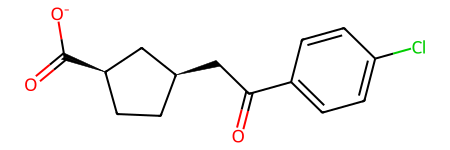

In [19]:
mols[100]

In [20]:
df_results = df[df['mol_id'].isin(result_id)]

In [37]:
df_results['tanimoto'] = df_results['mols'].apply(compute_tanimoto, args= (mols[100], ))

In [38]:
df_results

,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,n_rotatable_bonds,n_radical_electrons,tpsa,...,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings,mols,mol_id,tanimoto
0,370.108359,0.529412,5,2,3,7,24,3,0,53.85,...,2,1,0,1,0,2,2,<rdkit.Chem.rdchem.Mol object at 0x2aee67840>,Molecule 0,0.127660
1,351.275453,0.894737,6,2,3,6,25,4,0,57.09,...,3,0,0,0,1,2,3,<rdkit.Chem.rdchem.Mol object at 0x2aee678b0>,Molecule 1,0.076923
2,390.128110,0.473684,5,0,4,7,26,4,0,47.09,...,1,0,3,3,0,1,1,<rdkit.Chem.rdchem.Mol object at 0x2aee67920>,Molecule 2,0.081081
3,176.083730,0.181818,2,0,1,2,13,3,0,26.30,...,0,1,0,1,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x2aee67990>,Molecule 3,0.095890
4,357.151098,0.421053,5,1,3,6,25,5,0,62.30,...,1,1,1,2,1,0,1,<rdkit.Chem.rdchem.Mol object at 0x2aee67a00>,Molecule 4,0.132653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,266.101505,0.454545,8,3,2,8,19,4,0,113.33,...,1,0,1,1,0,1,1,<rdkit.Chem.rdchem.Mol object at 0x2aee86260>,Molecule 95,0.112360
96,310.054276,0.214286,4,2,2,6,20,6,0,54.27,...,0,1,1,2,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x2aee862d0>,Molecule 96,0.119565
97,336.067698,0.125000,5,2,2,7,23,5,0,67.43,...,0,2,0,2,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x2aee86340>,Molecule 97,0.172414
98,360.073766,0.133333,9,3,2,10,25,7,0,132.98,...,0,1,1,2,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x2aee863b0>,Molecule 98,0.118812


In [39]:
mols2grid.display(df_results, mol_col = 'mols', subset = ['mol_id', 'img', 'tanimoto'])

MolGridWidget()

Text(0.5, 1.0, 'Tanimoto distribution')

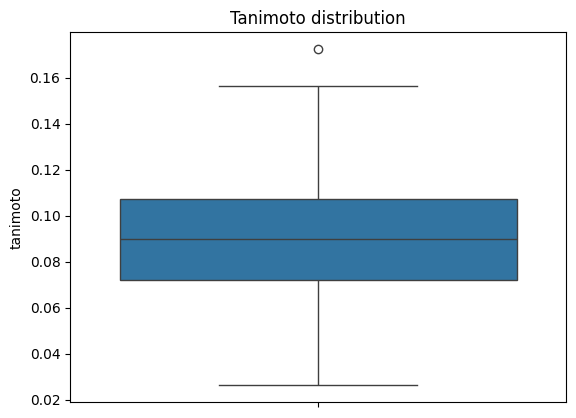

In [46]:
sns.boxplot(df_results['tanimoto'])
plt.title('Tanimoto distribution')

In [8]:
from molecule_generation import load_model_from_directory

model_dir = "/Users/rehanchinoy/repos/molecule-generation/tmp/MoLeR_checkpoint"
example_smiles = ["c1ccccc1", "CNC=O"]

with load_model_from_directory(model_dir) as model:
    samples = model.sample(num_samples = 200)
    
    # embeddings = model.encode(example_smiles)
    # print(f"Embedding shape: {embeddings[0].shape}")

    # # Decode without a scaffold constraint.
    # decoded = model.decode(embeddings)

    # # The i-th scaffold will be used when decoding the i-th latent vector.
    # decoded_scaffolds = model.decode(embeddings, scaffolds=["CN", "CCC"])

    print(f"Sampled: {samples}")
    # print(f"Encoded: {example_smiles}")
    # print(f"Decoded: {decoded}")
    # print(f"Decoded with scaffolds: {decoded_scaffolds}")

Loading a trained model from: /Users/rehanchinoy/repos/molecule-generation/tmp/MoLeR_checkpoint/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
2024-04-25 15:35:59.378368: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-25 15:35:59.379018: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-25 15:35:59.380517: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-25 15:35:59.403468: W tensorflow/core/platform/

Sampled: ['O=C1C2=CC=C(C3=CC=CC=C3)C=C=C2OC2=CC=CC=C12', 'CC(=O)NC1=NC2=CC(OCC3=CC=CN(CC4=CC=C(Cl)C=C4)C3=O)=CC=C2N1', 'CCN1C(=O)C2=CC=CC=C2N=C1NC(C)C(=O)NCC(=O)N=[N+]=[N-]', 'CC(=O)N1CCCC1C1=NC2=CC=C(C(C)(C)CCCC(C)C)C=C2NC1=NC1=CC=C(O)C=C1', 'N=C(N)NCCCCOC1=CC=C(Br)C(Cl)=N1', 'O=C1C2=CC=C(C3=NN=CO3)C=C2N=CN1CC1=CC=C(C2=CC=CC=C2)C=C1', 'O=CCCCCCN1C=CC2=CC=CC=C21', 'CCOC(=O)C1=CC2=CC(CC(C)C)=CC=C2N=C1C1=CC=C(Br)C=C1', 'CC1=C(C#N)C=C(NC(=O)NC2CCCCC2)N1CC#N', 'CC1=CNN=C1NC(=O)COC1=CC=C(Cl)C=C1Cl', 'O=C(O)C1=CC=C(C2CC3=CC=C(F)C=C3CO2)C=C1', 'CCCCCCCCCCN=C(O)C1=CC=CC=C1', 'CC1=CC=C(C)C(C2=CC=CC3=NC=CC=C23)=C1', 'CC(C)(C)C(=O)NC(CC=CC1=CC=NO1)CC1=CC=CN=C1', 'CC(C)N1C2=CC=C(Br)C=C2C(C2=CC=C(Cl)C=C2)=C1C1CNC1', 'COC1=CC2=C(C=C1NC(=O)CCC(=O)N1CCN(C(=O)CCCC3=CNC=N3)CC1)OCCSN2', 'CC1=CC=C2NCC(C)(C)OC2=C1', 'O=C(COC(=O)C1=CC=C2CCCCC2=C1)NC1=CC=C(OC2=CC=C(C3=CC=NC=C3)N=C2[N+](=O)[O-])C=C1', 'CC1=CC=C2C(=O)C3=CC=C(C(=O)NCC(F)(F)CSC4=NN=NN4)C=C3C(=O)C2=C1', 'COC1=CC=C(C)C2=C1C(=O)C1=CC=C(CCCCOC3=CC=C

In [17]:
smiles = ['CC(=O)OC1=CC=CC=C1C(=O)O',
'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O',
'CCC1=CC=C(C=C1)C(=O)C2=CC=CC=C2O',
'CC(C)CC1=CC=C(C=C1)C(=O)O',
'CC(=O)OC1=CC=C(C=C1)C2=CC=CC=C2N(=O)=O',
'CC1=C(C2=CC=CC=C2C(=O)O1)C3=CC=CC=C3Cl',
'CC1=CC(N(C1)C2=CC=C(C=C2)S(N)(=O)=O)C(F)(F)F',
'CC1=CN=C(N1C2=CC=C(C=C2)S(=O)(=O)C)C',
'CC(C)CC1=CC=C(C=C1)C(=O)OCCN2C=C(C(=O)C2=O)C',
'CC1=CC(N(C1)S(=O)(=O)N)C2=CC=C(C=C2)C3=CC=CO3']

In [16]:
drug_names = ['Aspirin',
'Ibuprofen',
'Naproxen',
'Ketoprofen',
'Diclofenac',
'Indomethacin',
'Celecoxib',
'Meloxicam',
'Etodolac',
'Piroxicam']

In [22]:
drug_names

['Aspirin',
 'Ibuprofen',
 'Naproxen',
 'Ketoprofen',
 'Diclofenac',
 'Indomethacin',
 'Celecoxib',
 'Meloxicam',
 'Etodolac',
 'Piroxicam']

In [23]:
similar_df = pd.DataFrame()

In [24]:
similar_df['drug_names'] = drug_names

In [25]:
similar_df['smiles'] = smiles

In [26]:
similar_df

,drug_names,smiles
0,Aspirin,CC(=O)OC1=CC=CC=C1C(=O)O
1,Ibuprofen,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O
2,Naproxen,CCC1=CC=C(C=C1)C(=O)C2=CC=CC=C2O
3,Ketoprofen,CC(C)CC1=CC=C(C=C1)C(=O)O
4,Diclofenac,CC(=O)OC1=CC=C(C=C1)C2=CC=CC=C2N(=O)=O
5,Indomethacin,CC1=C(C2=CC=CC=C2C(=O)O1)C3=CC=CC=C3Cl
6,Celecoxib,CC1=CC(N(C1)C2=CC=C(C=C2)S(N)(=O)=O)C(F)(F)F
7,Meloxicam,CC1=CN=C(N1C2=CC=C(C=C2)S(=O)(=O)C)C
8,Etodolac,CC(C)CC1=CC=C(C=C1)C(=O)OCCN2C=C(C(=O)C2=O)C
9,Piroxicam,CC1=CC(N(C1)S(=O)(=O)N)C2=CC=C(C=C2)C3=CC=CO3


In [27]:
mols2grid.display(similar_df, smiles_col = 'smiles')

MolGridWidget()

In [29]:
def compute_tanimoto(mol1, mol2):
    mol1 = Chem.MolFromSmiles(mol1)
    mol2 = Chem.MolFromSmiles(mol2)
    x = 1 - cdist([mol1], [mol2])[0]
    return x[0]

In [31]:
similar_df.smiles.iloc[0]

'CC(=O)OC1=CC=CC=C1C(=O)O'

In [32]:
similar_df['tanimoto'] = similar_df['smiles'].apply(compute_tanimoto, args = ([similar_df.smiles.iloc[0]]))

In [33]:
similar_df

,drug_names,smiles,tanimoto
0,Aspirin,CC(=O)OC1=CC=CC=C1C(=O)O,1.000000
1,Ibuprofen,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,0.148148
2,Naproxen,CCC1=CC=C(C=C1)C(=O)C2=CC=CC=C2O,0.232143
3,Ketoprofen,CC(C)CC1=CC=C(C=C1)C(=O)O,0.180000
4,Diclofenac,CC(=O)OC1=CC=C(C=C1)C2=CC=CC=C2N(=O)=O,0.233333
5,Indomethacin,CC1=C(C2=CC=CC=C2C(=O)O1)C3=CC=CC=C3Cl,0.119403
6,Celecoxib,CC1=CC(N(C1)C2=CC=C(C=C2)S(N)(=O)=O)C(F)(F)F,0.070423
7,Meloxicam,CC1=CN=C(N1C2=CC=C(C=C2)S(=O)(=O)C)C,0.098361
8,Etodolac,CC(C)CC1=CC=C(C=C1)C(=O)OCCN2C=C(C(=O)C2=O)C,0.105263
9,Piroxicam,CC1=CC(N(C1)S(=O)(=O)N)C2=CC=C(C=C2)C3=CC=CO3,0.076923


In [37]:
drugs = ['Acetaminophen',
'Phenacetin',
'Aniline',
'4-Aminopheno',
'4-Nitroaniline',
'Acetanilide',
'4-Acetamidophenol',
'4-Bromoaniline',
'4-Chloroaniline', 
'4-Methylaniline',]

In [38]:
smiles = ['CC(=O)NC1=CC=C(C=C1)O',
'CCOC1=CC=CC=C1C(=O)NC',
'C1=CC=C(C=C1)N',
'C1=CC(=CC=C1N)O',
'C1=CC(=CC=C1N+[O-])N',
'CC(=O)NC1=CC=CC=C1',
'CC(=O)NC1=CC=C(C=C1)O',
'C1=CC(=CC=C1Br)N',
'C1=CC(=CC=C1Cl)N',
'CC1=CC(=CC=C1N)C']

In [39]:
similar = pd.DataFrame()

In [40]:
similar['drugs'] = drugs

In [41]:
similar['smiles'] = smiles

In [46]:
similar = similar.drop(4)

In [48]:
similar['tanimoto'] = similar['smiles'].apply(compute_tanimoto, args = ([similar.smiles.iloc[0]]))

In [49]:
similar

,drugs,smiles,tanimoto
0,Acetaminophen,CC(=O)NC1=CC=C(C=C1)O,1.000000
1,Phenacetin,CCOC1=CC=CC=C1C(=O)NC,0.150943
2,Aniline,C1=CC=C(C=C1)N,0.085714
3,4-Aminopheno,C1=CC(=CC=C1N)O,0.281250
5,Acetanilide,CC(=O)NC1=CC=CC=C1,0.484848
6,4-Acetamidophenol,CC(=O)NC1=CC=C(C=C1)O,1.000000
7,4-Bromoaniline,C1=CC(=CC=C1Br)N,0.078947
8,4-Chloroaniline,C1=CC(=CC=C1Cl)N,0.078947
9,4-Methylaniline,CC1=CC(=CC=C1N)C,0.095238


In [42]:
mols2grid.display(similar, smiles_col = 'smiles')

MolGridWidget()

In [4]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [5]:
designer = sf.SAFEDesign.load_default()

designer.model

: 

In [ ]:
scaffold = "[*]N-c1ccc2ncnc(-N[*])c2c1"

dm.to_image(scaffold)

In [5]:
generated_smiles = sf.scaffold_decoration(
    scaffold=scaffold,
    n_samples_per_trial=12,
    n_trials=2,
    sanitize=True,
    do_not_fragment_further=True,
)

generated_mols = [dm.to_mol(x) for x in generated_smiles]

AttributeError: module 'safe' has no attribute 'scaffold_decoration'

In [ ]:
dm.viz.lasso_highlight_image(generated_mols[:12], dm.from_smarts(scaffold), mol_size=(350, 200), color_list=["#ff80b5"], scale_padding=0.1)
